# <b> Content

---

- [Packages](#1)
- [Data Wrangling](#2)
  - [Importing and Loading Dataset](#2-1)
  - [Dataset Description](#2-2)
  - [Training Dataset Inspection](#2-3)
  - [Testing Dataset Inspection](#2-4)
- [Data Preprocessing](#3)
  - [Data Augumentation](#3-1)
    - [Data Augumentation Modelling](#3-1.1)
    - [Data Augumentation Implementation](#3-1.2)
- [Deep Learning - Convolutional Neural Network](#4)
  - [Vinnet - Modelling](#4-1)
  - [Vinnet - Model Visualization](#4-2)
  - [Vinnet - Model Monitoring Functions](#4-3)
  - [Vinnet - Model Training](#4-4)
  - [Vinnet - Model Performance Visualization](#4-5)
  - [Vinnet - Model Evaluation](#4-6)
    - [Training set Evaluation](#4-6.1)
    - [Testing set Evaluation](#4-6.2)
    - [Storing Optimal Weights of Vinnet Model](#4-6.3)
    - [Testing Vinnet Model using new data](#4-6.4)
- [Conclusion](#5)

<a name = '1'></a>
# <b> Packages

---
> Necessary Libraries for performing analysis and implementation of Emotion Classifier using Deep Learning


In [ ]:
# Libraries for Data Manupulation
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io

# Libraries for Data Visualization
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from mlxtend.plotting import plot_confusion_matrix

# Libraries for Image Preprocessing
import cv2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img

# Libraries for Train Test Split
from sklearn.model_selection import train_test_split

# Libraries for Deep Learning
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense , Activation , Dropout ,Flatten

# Libraries for Normalizing
from keras.layers import BatchNormalization

# Libraries for Evaluating the model
from keras import regularizers
from keras.models import model_from_json
from keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger, TensorBoard

# Library to suppress warnings
import warnings
warnings.filterwarnings('ignore')

print('All libraries are imported Successfully :)')

All libraries are imported Successfully :)


<a name = '2'></a>
# <b> Data Wrangling

---
> It involves preparing dataset such as Data Augumentation and Data Engineering.


<a name = '2-1'></a>
## <b> Importing and Loading Dataset

In [ ]:
# Reading the dataset from drive
train_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/train/'
test_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/test/'

In [ ]:
# Function to read the dataset
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

In [ ]:
# Loading the dataset
train_df = count_exp(train_dir, 'train')
test_df = count_exp(test_dir, 'test')

<a name='2-2'></a>
## <b> Dataset Description

---
> The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.
>
> The task is to categorize each face based on the emotion shown in the facial expression in to one of Seven categories.
> * 0	Happy
> * 1	Angry
> * 2	Surprise
> * 3	Sad
> * 4	Neutral
> * 5 Fear
> * 6 Disgust
>
> We define a CNN model and compare the predicted results with given labels.


<a name = '2-3'></a>
## <b> Training Dataset Inspection

In [ ]:
# Looking into the training data
print(train_df)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171


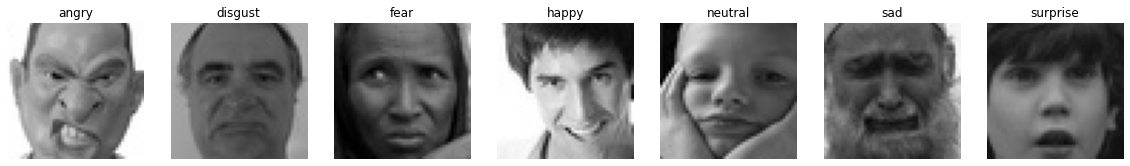

In [ ]:
# Visualizing the train dataset
plt.figure(figsize=(20,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

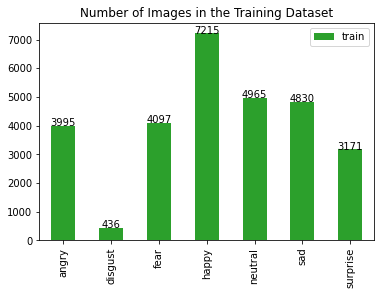

<Figure size 2160x864 with 0 Axes>

In [ ]:
# Looking at the distribution of training dataset
ax = train_df.transpose().plot(kind='bar',color='tab:green')
plt.title('Number of Images in the Training Dataset', fontsize=12)
plt.figure(figsize=(30,12))
for i in ax.patches:
    height = i.get_height()
    width = i.get_width()
    ax.text(i.get_x() + width/2, height + 1,height ,ha="center")

<a name = '2-4'></a>
## <b> Testing Dataset Inspection

In [ ]:
# Looking into the testing data
print(test_df)

      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


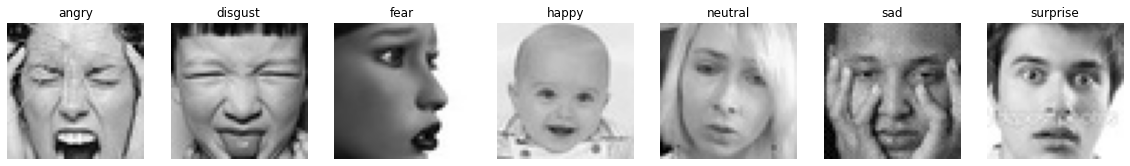

In [ ]:
# Visualizing the test dataset
plt.figure(figsize=(20,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

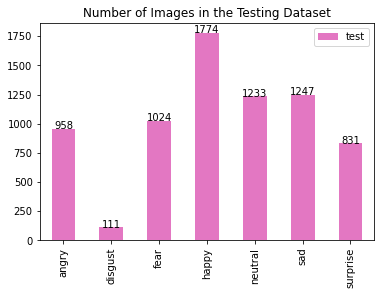

<Figure size 2160x864 with 0 Axes>

In [ ]:
# Looking at the distribution of testing dataset
ax = test_df.transpose().plot(kind='bar',color='tab:pink')
plt.title('Number of Images in the Testing Dataset', fontsize=12)
plt.figure(figsize=(30,12))
for i in ax.patches:
    height = i.get_height()
    width = i.get_width()
    ax.text(i.get_x() + width/2, height + 1,height ,ha="center")

<a name = '3'></a>
# <b> Data Preprocessing

In [ ]:
# Inputs for data preprocessing
num_of_classes = 7
img_shape = 224,224,3
batch_size = 64

<a name = '3-1'></a>
## <b> Data Augumentation

---
> Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. 
>
>It acts as a regularizer and helps reduce overfitting when training a machine learning model. It is closely related to oversampling in data analysis.


<a name = '3-1.1'></a>
### <b> Data Augumentation Modelling

In [ ]:
# Applying ImageDataGenerator method for data augumentation on train set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

In [ ]:
# Applying ImageDataGenerator method for data augumentation on test set
validation_datagen = ImageDataGenerator(rescale=1./255)

<a name = '3-1.2'></a>
### <b> Data Augumentation Implementation

In [ ]:
# Implementing flow from directory method on training set
train_gen = train_datagen.flow_from_directory(train_dir,color_mode='rgb',
				                                      target_size=(224,224),
				                                      batch_size=batch_size,
				                                      class_mode='categorical',
				                                      shuffle=True)

Found 28709 images belonging to 7 classes.


In [ ]:
# Implementing flow from directory method on testing set
valid_gen = validation_datagen.flow_from_directory(test_dir,color_mode='rgb',
							                                     target_size=(224,224),
							                                     batch_size=batch_size,
							                                     class_mode='categorical',
							                                     shuffle=True)

Found 7178 images belonging to 7 classes.


In [ ]:
# Looking at training set classes
train_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
# Looking at testing set classes
valid_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

<a name = '4'></a>
# <b> Deep Learning - Convolutional Neural Network Implementation

---
> Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised. 
>
> In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network, most commonly applied to analyze visual imagery. 
>
> They have applications in image and video recognition, recommender systems, image classification, image segmentation, medical image analysis, natural language processing, brain-computer interfaces, and financial time series.


<a name = '4-1'></a>
## <b> Vinnet - Modelling

In [ ]:
# Modelling of convolutional neural networks  
# MobileNetV2 - Transfer Learning
base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet')
base_input = base_model.layers[0].input
base_output = base_model.layers[-2].output

# Block 1
model = layers.Dense(512, activation='relu')(base_output)
  
# Block 2
model = layers.Dense(128, activation='relu')(model)
  
# Block 3
model = layers.Dense(64, activation='relu')(model)
model = layers.Dense(num_of_classes,activation = 'softmax')(model)

In [ ]:
# Looking at the model summary
vinnet = Model(inputs = base_input, outputs = model)
vinnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# Model Compile
vinnet.compile(loss='categorical_crossentropy',
              optimizer=Adam(decay=1e-6),
              metrics=['accuracy'])

<a name='4-2'></a>
## <b> Vinnet - Model Visualization

In [ ]:
# Visualizing the vinnet model
plot_model(vinnet, to_file='/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/vinnet.png', 
           show_shapes=True, show_layer_names=True, show_dtype=True)

Output hidden; open in https://colab.research.google.com to view.

<a name = '4-3'></a>
## <b> Vinnet - Model Monitoring Functions

In [ ]:
# Model call back functions
# Model Checkpoint
file_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Vinnet.h5'
checkpoint = ModelCheckpoint(filepath= file_dir,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

# Model Early Stopping
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.00001,
                           patience=10,
                           verbose=1,
                           restore_best_weights=True)

# Model Learning Rate Reduction
learn_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                    patience=4, 
                                    verbose=1, 
                                    factor=0.1, 
                                    min_lr=0.0000001)

log_dir = "/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Csv Logger
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, early_stop, learn_reduction, csv_logger]

<a name='4-4'></a>
## <b> Vinnet - Model Training

In [ ]:
# Vinnet - Model Training
history = vinnet.fit(x = train_gen,
                     validation_data = valid_gen,
                     epochs=50,
                     callbacks=callbacks,
                     steps_per_epoch=train_gen.n//train_gen.batch_size,
                     validation_steps=valid_gen.n//valid_gen.batch_size)

Epoch 1/50
448/448 [==============================] - 10402s 23s/step - loss: 1.3394 - accuracy: 0.4910 - val_loss: 6.7755 - val_accuracy: 0.1695

Epoch 00001: val_loss improved from inf to 6.77549, saving model to /content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Vinnet.h5
Epoch 2/50
448/448 [==============================] - 311s 694ms/step - loss: 1.1382 - accuracy: 0.5721 - val_loss: 5.4817 - val_accuracy: 0.1575

Epoch 00002: val_loss improved from 6.77549 to 5.48171, saving model to /content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Vinnet.h5
Epoch 3/50
448/448 [==============================] - 310s 692ms/step - loss: 1.0770 - accuracy: 0.5972 - val_loss: 3.7762 - val_accuracy: 0.4407

Epoch 00003: val_loss improved from 5.48171 to 3.77620, saving model to /content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Vinnet.h5
Epoch 4/50
448/448 [======

<a name = '4-5'></a>
## <b> Vinnet - Model Performance Visualization

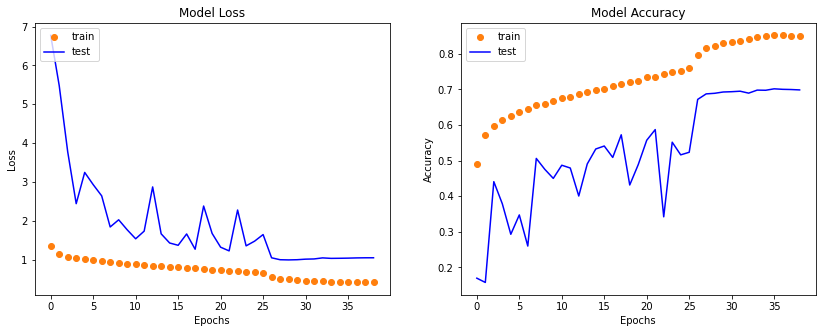

In [ ]:
# Plotting the loss and accuracy of vinnet model
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],'bo',color='tab:orange')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'],'bo', color='tab:orange')
plt.plot(history.history['val_loss'],'b')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<a name = '4-6'></a>
## <b> Vinnet - Model Evaluation

<a name = '4-6.1'></a>
### <b> Training set Evaluation

In [ ]:
# Evaluating Vinnet model training accuracy
print("Evaluate on train data")
results = vinnet.evaluate(train_gen, batch_size=64)
print("train loss, train acc:", results)
print("final train accuracy = {:.2f}".format(results[1]*100))

Evaluate on train data
449/449 [==============================] - 291s 649ms/step - loss: 0.4701 - accuracy: 0.8255
train loss, train acc: [0.47013044357299805, 0.8254902362823486]
final train accuracy = 82.55


<a name = '4-6.2'></a>
### <b> Testing set Evaluation

In [ ]:
# Evaluating Vinnet model testing accuracy
print("Evaluate on test data")
predictions = vinnet.evaluate(valid_gen, batch_size=64)
print("test loss, test acc:", predictions)
print("final test accuracy = {:.2f}".format(predictions[1]*100))

Evaluate on test data
113/113 [==============================] - 13s 111ms/step - loss: 0.8479 - accuracy: 0.6904
test loss, test acc: [0.847916841506958, 0.6904430389404297]
final test accuracy = 69.04


<a name = '4-6.3'></a>
### <b> Storing Optimal Weights of Vinnet Model

In [ ]:
# Storing the optimal weights of the vinnet model
file_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Optimal_Model/vinnetOptimalmodel4.h5'
vinnet.save_weights(file_dir)

In [ ]:
# Loading the optimal weights of the vinnet model
vinnet.load_weights('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Optimal_Model/vinnetOptimalmodel3.h5')

In [ ]:
# Evaluating Vinnet model testing accuracy
predictions = vinnet.evaluate(valid_gen, batch_size=128)
pred = vinnet.predict(valid_gen)
print("test loss, test acc:", predictions)
print("Pretrained Model Accuracy = {:.2f}".format(predictions[1]*100))

113/113 [==============================] - 13s 112ms/step - loss: 0.8479 - accuracy: 0.6904
test loss, test acc: [0.8479166030883789, 0.6904430389404297]
Pretrained Model Accuracy = 69.04


<a name = '4-6.4'></a>
### <b> Testing Vinnet Model using new data

In [ ]:
# Function for Predicting new Image
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [ ]:
# Allocating labels for Predicted Probabilies
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


#### <b> 1. Original Label - Angry

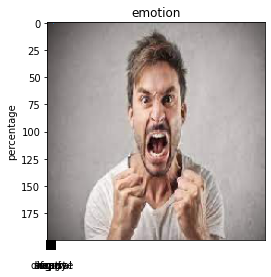

Expression Prediction: surprise


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/1.angry.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/1.angry.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 2.Original Label - Disgust

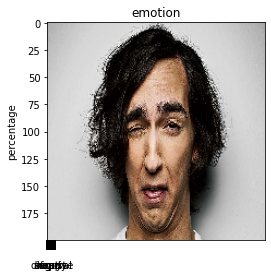

Expression Prediction: fear


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/2.disgust.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/2.disgust.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 3.Original Label - Fear

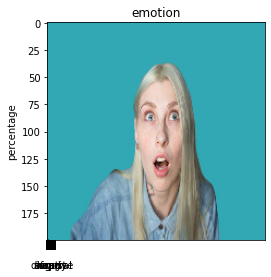

Expression Prediction: fear


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/3.fear.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/3.fear.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 4.Original Label - Fear

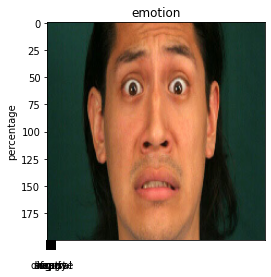

Expression Prediction: fear


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/4.fear.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/4.fear.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 5.Original Label - Happy

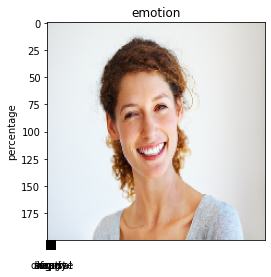

Expression Prediction: happy


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/5.happy.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/5.happy.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 6.Original Label - Happy

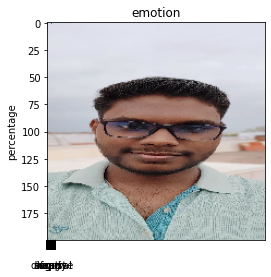

Expression Prediction: happy


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/6.happy.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/6.happy.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 7.Original Label - Disgust

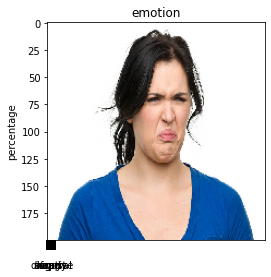

Expression Prediction: sad


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/7.disgust.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/7.disgust.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 8.Original Label - Sad

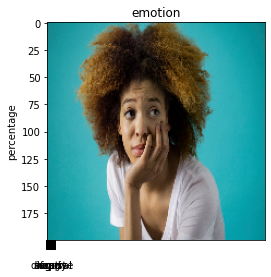

Expression Prediction: sad


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/8.sad.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/8.sad.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 9.Original Label - Sad

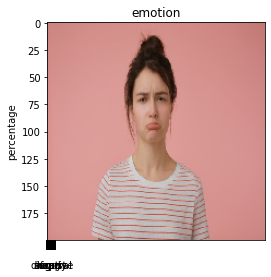

Expression Prediction: sad


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/9.sad.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/9.sad.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

#### <b> 10.Original Label - Angry

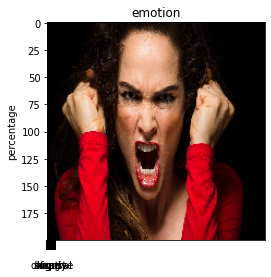

Expression Prediction: angry


In [ ]:
# Testing new image
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/10.angry.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/sample_Images/10.angry.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = vinnet.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224, 224, 3]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

<a name = '5'></a>
# <b> Conclusion

---
> * After successful training of vinnet model using train dataset.
> * It is tested using valid dataset.
> * Then model is evaluated with train dataset to find final train accuracy which was around = 82.55.
> * Similarly the model was also evaluated with valid dataset to find final test accuracy which was around = 69.04.
> * Further model was tested with new sets of data. Those datas are not in both train and valid dataset.
> * Out of 10 data 7 were correctly Predicted by our vinnet model. Only 3 were wrongly predicted.
> * Based on the above evaluation and testing our vinnet model is ready for deployment to the real world.

